<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/UN_decade_banner.png' align='right' width='100%'/>

<a href="../../../../Index.ipynb"><< Index</a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2024 EUMETSAT <br>
**License:** MIT <br>
**Authors:** Ben Loveday (EUMETSAT/Innoflair UG), Hayley Evers-King (EUMETSAT), Marie Smith (CSIR)

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fapplications%2Focean-case-studies/HEAD?urlpath=%2Ftree%2FCase_studies%2FUN_Ocean_Decade%2FChallenge03_sustainable_food%2FDeoxygenation_impacts_marine_life_benguela.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
  <div style="width:100%">
    <div style="float:left"><a href="https://jupyterhub-wekeo.apps.eumetsat.dpi.wekeo.eu/hub/user-redirect/lab/tree/public/wekeo4oceans/ocean-case-studies/Case_studies/UN_Ocean_Decade/Challenge03_sustainable_food/Deoxygenation_impacts_marine_life_benguela.ipynb"><img src="https://img.shields.io/badge/launch-WEKEO-1a4696.svg?style=flat&logo=" alt="Open in WEkEO"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Ocean case studies</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>

This notebook has the following prerequisites:
- **<a href="https://eoportal.eumetsat.int/" target="_blank">A EUMETSAT Earth Observation Portal account</a>** to download data from the EUMETSAT Data Store

There are no prerequisite notebooks for this module, but you may wish to look at the following notebooks on using OLCI data; <br>
- **<a href="https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/sensors/learn-olci" target="_blank">Learn OLCI (EUMETSAT Gitlab)</a>**

For more contextual information, users should refer to the following case study where the image we generate here is published:
- **<a href="https://user.eumetsat.int/resources/case-studies/deoxygenation-impacts-marine-life-in-the-benguela" target="_blank">Deoxygenation impacts marine life in the Benguela</a>**

</div>
<hr>

# Deoxygenation impacts marine life in the Benguela
<font color="#138D75">**UN Ocean Decade Challenge 3: Sustainably feed the global population**</font>

### Data used

| Dataset | EUMETSAT Data Store<br>collection ID| EUMETSAT collection<br>description | WEkEO dataset ID | WEkEO description |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:-----------------:|
| Sentinel-3 OLCI level-2 full resolution | EO:EUM:DAT:0407 | <a href="https://user.eumetsat.int/catalogue/EO:EUM:DAT:SENTINEL-3:OL_2_WFR___NTC" target="_blank">Description</a> | EO:EUM:DAT:SENTINEL-3:OL_2_WFR___ | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-3%3AOL_2_WFR___" target="_blank">Description</a> |

### Learning outcomes

At the end of this notebook you will know how to ;
* download OLCI Level-2 data for South Africa's west coast on February 26th, 2022
* plot an OLCI band ratio chlorophyll product over the region


### Outline

This code will replicate figure 1 from this case study; **<a href="https://user.eumetsat.int/resources/case-studies/deoxygenation-impacts-marine-life-in-the-benguela" target="_blank">Deoxygenation impacts marine life in the Benguela</a>**.

<div class="alert alert-info" role="alert">

## <a id='TOCTOP'></a>Contents

</div>

 1. [Step 1: Setting up our analysis](#section1)
 1. [Step 2: Acquiring OLCI data](#section2)
 1. [Step 3: Reading OLCI reflectance data](#section3)
 1. [Step 4: Plotting OLCI data](#section4)

<hr>

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Setting up our analysis
[Back to top](#TOCTOP)

</div>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../../../README.md" target="_blank">README</a>**.

In [1]:
import cartopy                               # a package that helps with mapping and projection management
import glob                                  # a package that helps with file searching
import matplotlib.pyplot as plt              # a library that facilitates plotting
import matplotlib.ticker as mticker          # a library that facilitates plotting
import matplotlib.patheffects as PathEffects # a library that facilitates plotting
import numpy as np                           # a library that lets us work with arrays; we import this with a new name "np"
import os                                    # a library that allows us access to basic operating system commands like making directories
import shutil                                # a library that allows us access to basic operating system commands like copy
import xarray as xr                          # a powerful library that facilitates working with arrays
import zipfile                               # a library that allows us to unzip zip-files.
import eumartools                            # a library package for helping to work with Sentinel-3 data
import eumdac                                # a tool that helps us download via the eumetsat/data-store
import warnings                              # a library that helps us handle warnings
from pathlib import Path                     # a library to help us to construct system paths
import getpass                               # a library to help us enter passwords

warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 12})

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Acquiring OLCI data
[Back to top](#TOCTOP)

</div>

We will begin by creating a directory for our downloaded data

In [2]:
# Create a download directory for our OLCI products
download_dir = os.path.join(os.getcwd(), "products")
os.makedirs(download_dir, exist_ok=True)

Next, we define a switch that determines if we should download new data. If `download_data = False` the notebook will look for existing, locally processed data, saving us time if we run more than once. By default this is set to true, assuming that the notebook has not yet been run.

In [3]:
# Settings
download_data = True

We are going to retrieve the OLCI data from the EUMETSAT Data Store. Collections are stored according to their `collection id`, which for OLCI Level-2 full resolution products is `EO:EUM:DAT:0407` (as specified in the "Data Used" section above). We will also provide the relevant products we want from this collection, which in this case is two granules. For more information on how to search for the data you want, please see the Learn OLCI Gitlab link above.

In [4]:
collection_id = 'EO:EUM:DAT:0407'
product_list = ['S3A_OL_2_WFR____20220220T080053_20220220T080353_20220221T184925_0179_082_149_3420_MAR_O_NT_003.SEN3',
                'S3A_OL_2_WFR____20220220T080353_20220220T080653_20220221T184943_0180_082_149_3600_MAR_O_NT_003.SEN3']

<div class="alert alert-block alert-success">

### Accessing the EUMETSAT Data Store

To access Copernicus marine data from the <a href="https://data.eumetsat.int " target="_blank">EUMETSAT Data Store</a>, we will use the EUMETSAT Data Access Client (`eumdac`) python package. If you are working with the recommended Anaconda Python distribution and used the environment file included in this repository (environment.yml) to build this python environment (as detailed in the README), you will already have installed this. If not, you can install eumdac using;

`conda install -c eumetsat eumdac`

You can also find the source code on the <a href="https://gitlab.eumetsat.int/eumetlab/data-services/eumdac " target="_blank">EUMETSAT GitLab</a>. Please visit the EUMETSAT user portal for more information on the <a href="https://user.eumetsat.int/data-access/data-store " target="_blank">EUMETSAT Data Store</a> and <a href="https://user.eumetsat.int/resources/user-guides/eumetsat-data-access-client-eumdac-guide " target="_blank">eumdac</a>.

To download data from the EUMETSDAT Data Store via API, you need to provide credentials. To obtain these you should first register at for an <a href="https://eoportal.eumetsat.int/" target="_blank">EUMETSAT Earth Observation Portal account</a>. Once you have an account, you can retrieve your `<your_consumer_key>` and `<your_consumer_secret>` from the <a href="https://api.eumetsat.int/api-key/ " target="_blank">"EUMETSAT Data Store API"</a> page (*Note: you must click the "Show hidden fields" button at the bottom of the page to see the relevant fields*). If you do not already have a local credentials file, you will be prompted to enter your credentials when you run the cell below. This will create the required local credentials file, so that you only need to run this once.

*Note: your key and secret are permanent, so you should take care to never share them*

</div>

In [5]:
# load credentials
eumdac_credentials_file = Path(Path.home() / '.eumdac' / 'credentials')

if os.path.exists(eumdac_credentials_file):
    consumer_key, consumer_secret = Path(eumdac_credentials_file).read_text().split(',')
else:
    # creating authentication file
    consumer_key = input('Enter your consumer key: ')
    consumer_secret = getpass.getpass('Enter your consumer secret: ')
    try:
        os.makedirs(os.path.dirname(eumdac_credentials_file), exist_ok=True)
        with open(eumdac_credentials_file, "w") as f:
            f.write(f'{consumer_key},{consumer_secret}')
    except:
        pass
        
token = eumdac.AccessToken((consumer_key, consumer_secret))
print(f"This token '{token}' expires {token.expiration}")

This token 'bdcbc2bd-6aa4-303c-b8a8-bd3e0a538ca3' expires 2024-04-18 12:08:16.347605


Now we have a token, we can create an instance of the EUMETSAT Data Store.

In [6]:
datastore = eumdac.DataStore(token)

We can now ask the Data Store for our specified products. The box below will download them in sequence, unzip them and tidy up.

In [7]:
if download_data:    
    for product_id in product_list:
        print(f"Retrieving: {product_id} from {collection_id}")

        # find the required products
        selected_product = datastore.get_product(product_id=product_id, collection_id=collection_id)

        # download the required products
        with selected_product.open() as fsrc, open(os.path.join(download_dir, fsrc.name), mode='wb') as fdst:
            print(f'Downloading {fsrc.name}.')
            shutil.copyfileobj(fsrc, fdst)
            print(f'Download of product {fsrc.name} finished.')

        # Unzip the required products
        with zipfile.ZipFile(fdst.name, 'r') as zip_ref:
            for file in zip_ref.namelist():
                if file.startswith(str(selected_product)):
                    zip_ref.extract(file, download_dir)
            print(f'Unzipping of product {fdst.name} finished.')

        # tidy up the required products
        os.remove(fdst.name)

Retrieving: S3A_OL_2_WFR____20220220T080053_20220220T080353_20220221T184925_0179_082_149_3420_MAR_O_NT_003.SEN3 from EO:EUM:DAT:0407
Download of product S3A_OL_2_WFR____20220220T080053_20220220T080353_20220221T184925_0179_082_149_3420_MAR_O_NT_003.SEN3.zip finished.
Unzipping of product /Users/benloveday/Code/Git_Reps/CMTS/internal/applications/ocean-case-studies/Case_studies/UNOD/Ch03/Deoxygenation_benguela/products/S3A_OL_2_WFR____20220220T080053_20220220T080353_20220221T184925_0179_082_149_3420_MAR_O_NT_003.SEN3.zip finished.
Retrieving: S3A_OL_2_WFR____20220220T080353_20220220T080653_20220221T184943_0180_082_149_3600_MAR_O_NT_003.SEN3 from EO:EUM:DAT:0407
Download of product S3A_OL_2_WFR____20220220T080353_20220220T080653_20220221T184943_0180_082_149_3600_MAR_O_NT_003.SEN3.zip finished.
Unzipping of product /Users/benloveday/Code/Git_Reps/CMTS/internal/applications/ocean-case-studies/Case_studies/UNOD/Ch03/Deoxygenation_benguela/products/S3A_OL_2_WFR____20220220T080353_20220220T080

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Reading OLCI reflectance data
[Back to top](#TOCTOP)

</div>

Blooms in the Benguela tend to be very high in biomass and have high Chlorophyll concentrations. Consequently, standard retrieval algorithms often do not perform well here. To get a better approximation we are going to use a red-band ratio algorithm based on the 665 n and 709 nm bands, that has been show to work well in the region (<a href="https://link.springer.com/chapter/10.1007/978-94-017-8008-7_10" target="_blank">Bernard et al., 2014</a>). For this, we need to read in the two reflectance bands, the geolocation points and the flag field. The latter will allow us to make out erroneous points (e.g. due to cloud). The band ratio can be calculated using;

$[Chl-a] = 227.25 * e^{-2.815 *(Rrs_{665}/Rrs_{709})}$

We will switch between the use of the standard OC4ME algorithm to the band ratio algorithm where the chlorophyll concentration is higher than 1 in the former.

In [8]:
# makes area average
subset_box_lons = [17, 17, 19, 19, 17]
subset_box_lats = [-33, -31, -31, -33, -33]

In [9]:
SAFE_directories = glob.glob(os.path.join(download_dir,'*.SEN3'))

In [18]:
chls = []
lons = []
lats = []
flag_masks = []

for SAFE_directory in SAFE_directories:

    # read and subset coords
    geo_file = os.path.join(SAFE_directory,'geo_coordinates.nc')
    geo_fid = xr.open_dataset(geo_file)
    lon = geo_fid.longitude.data
    lat = geo_fid.latitude.data
    ii, jj, region_mask = eumartools.subset_image(lon, lat, subset_box_lons, subset_box_lats) 
    geo_fid.close()
    lons.append(lon[min(jj):max(jj), min(ii):max(ii)])
    lats.append(lat[min(jj):max(jj), min(ii):max(ii)])

    # read and subset band vars
    band_vars = xr.open_mfdataset(glob.glob(os.path.join(SAFE_directory,'Oa*.nc')))
    ref_665 = np.array(band_vars['Oa08_reflectance'].data[min(jj):max(jj), min(ii):max(ii)])
    ref_709 = np.array(band_vars['Oa11_reflectance'].data[min(jj):max(jj), min(ii):max(ii)])
    band_vars.close()
    
    # read and subset OC4ME CHL
    chl_vars = xr.open_mfdataset(glob.glob(os.path.join(SAFE_directory,'chl_oc4me*.nc')))
    chl = np.array(chl_vars['CHL_OC4ME'].data[min(jj):max(jj), min(ii):max(ii)])
    chl_vars.close()    
    
    # reading masks: example flags
    flag_file = os.path.join(SAFE_directory,'wqsf.nc')
    flag_mask = eumartools.flag_mask(flag_file, 'WQSF',
                                     ['CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 
                                      'INVALID', 'HISOLZEN','HIGHGLINT',
                                      'COSMETIC','SUSPECT','SATURATED'])

    flag_mask = flag_mask.astype(float)[min(jj):max(jj), min(ii):max(ii)]
    flag_mask[flag_mask == 0.0] = np.nan
    flag_masks.append(flag_mask)
    
    # calculate band ratio
    ref_665[flag_mask == 1] = np.nan
    ref_709[flag_mask == 1] = np.nan
    band_ratio = np.log10(227.25 * np.exp(-2.815*ref_665/ref_709))
    chl[flag_mask == 1] = np.nan

    # switch at 1
    band_ratio[chl < np.log10(1)] = chl[chl < np.log10(1)]
    chls.append(band_ratio)

<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Plotting OLCI data
[Back to top](#TOCTOP)

</div>

Now that we have calculated our band ratio for each product we will plot them using the box below. Thsi plot routine will render each image in succession and then embellish with a few annotations at the end. It will save the output image as a png.

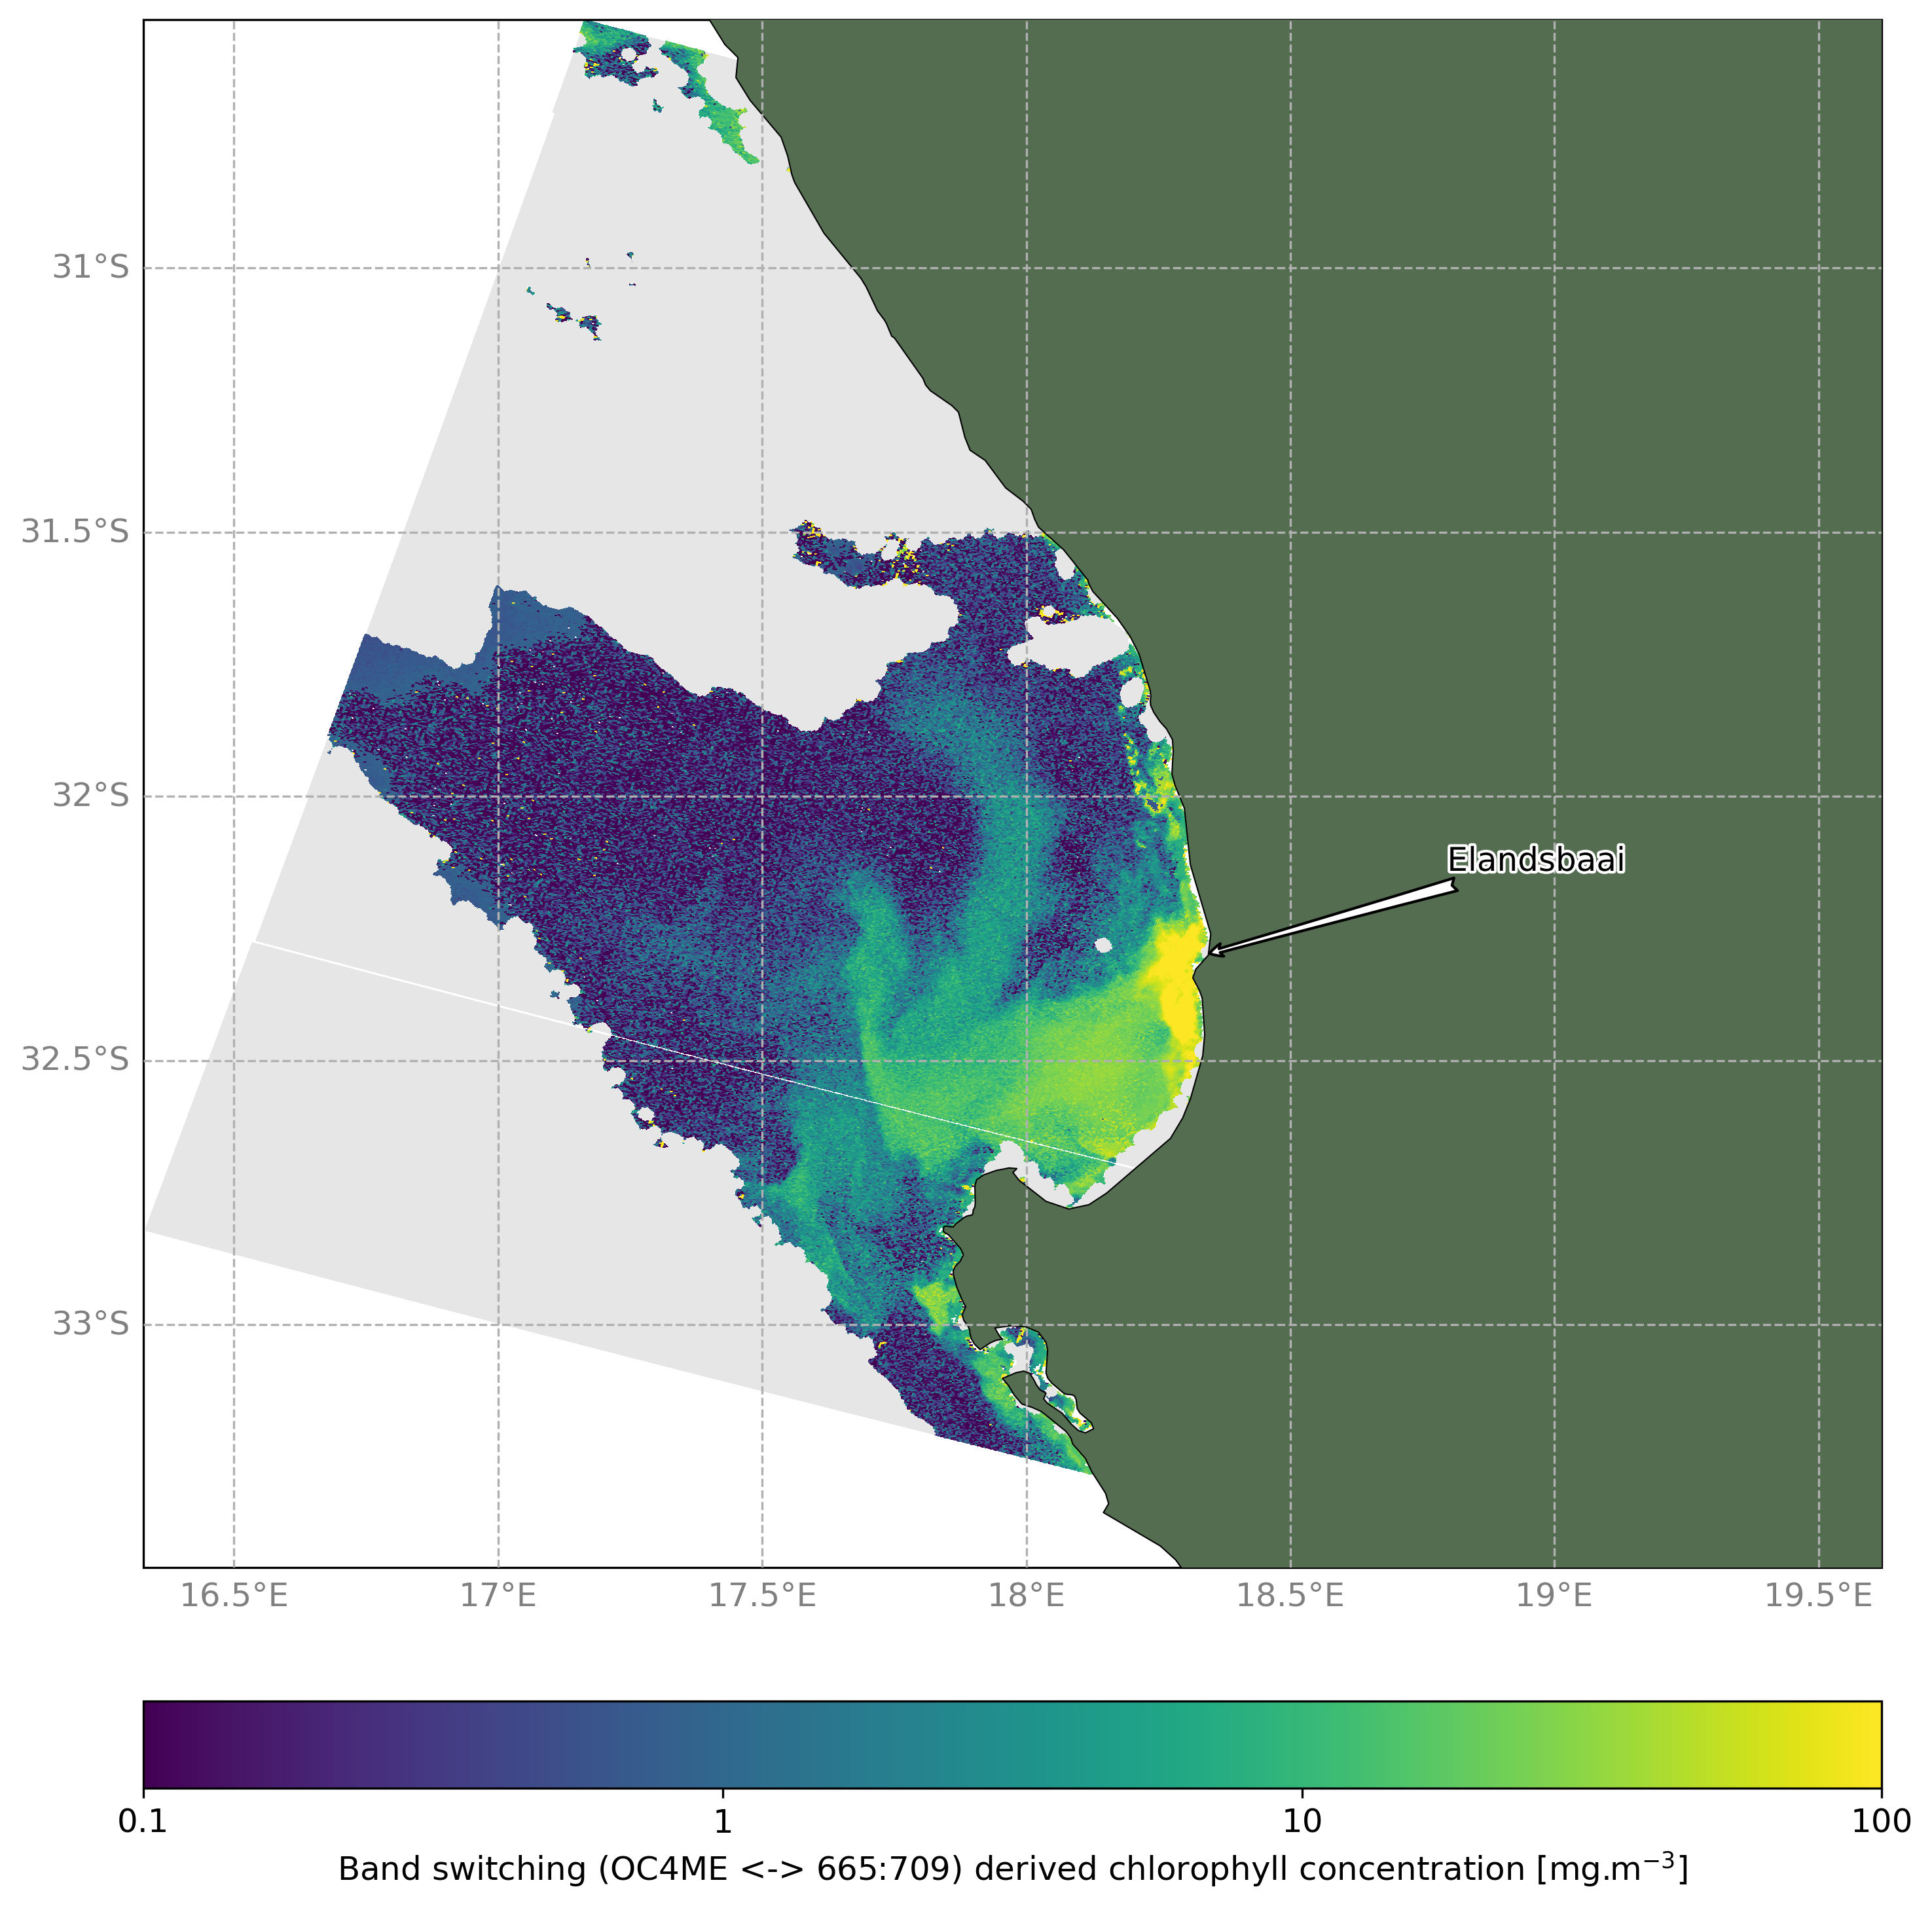

In [19]:
# set up our figure
fig, m = plt.subplots(1, 1, figsize=(10, 14), dpi=300, subplot_kw={"projection": cartopy.crs.PlateCarree()})

# plot our ocean colour products
for chl, lon, lat, flag_mask in zip(chls, lons, lats, flag_masks):

    p1 = m.pcolormesh(lon, lat, chl, cmap=plt.cm.viridis, vmin=-1, vmax=2, zorder=1, transform = cartopy.crs.PlateCarree())

    m.contourf(lon, lat, flag_mask, levels=[0,1], colors='0.9', zorder=4, transform = cartopy.crs.PlateCarree())

# add our location notation and arrow
txt = m.annotate('Elandsbaai', xy=(18.3369, -32.3003),  xycoords='data',
        xytext=(0.75, 0.45), textcoords='axes fraction', color='k',
        arrowprops=dict(arrowstyle="fancy", facecolor='white'),
        zorder=100)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

# add some map embellishments
m.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='k', facecolor='#546d51', linewidth=0.5), zorder=8)
g1 = m.gridlines(draw_labels = True, linestyle='--', zorder=10)
g1.top_labels = g1.right_labels = False
g1.xlabel_style = g1.ylabel_style = {'color': 'gray'}

# add a colour bar
cbar = fig.colorbar(p1, ax=m, location='bottom', pad=0.05)
ticks = [-1,0,1,2]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**tick for tick in ticks])
cbar.set_label('Band switching (OC4ME <-> 665:709) derived chlorophyll concentration [mg.m$^{-3}$]')

# output the figure
plt.tight_layout()
plt.savefig('Coastal_deoxygenation_South_African_red_tides_OLCI.png', bbox_inches='tight')

*Note that the band ratio algorithm is prone to stretching the colour scale due to outliers. The plot above is limited to only show values in the range specified by the colour bar.*

<hr>
<a href="../../../../Index.ipynb"><< Index</a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/applications/ocean-case-studies">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>